In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense, GRU, MultiHeadAttention, LayerNormalization, TimeDistributed
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re

# CSV 파일 읽기
data = pd.read_csv("최종목록_진짜최종(찐으로끝).csv")

# 속성 선택
selected_data = data[['자료명 저자', '책소개']]

# 텍스트 전처리: 모든 특수 문자 및 한자 제거, 소문자 변환 등
def clean_text(text):
    # 모든 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 한자 제거
    text = re.sub(r'[\u4e00-\u9fff]+', '', text)
    # 소문자 변환
    text = text.lower()
    return text

selected_data['책소개'] = selected_data['책소개'].apply(clean_text)

# 텍스트를 단어 리스트로 변환
tokenized_texts = selected_data['책소개'].apply(lambda x: x.split())

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=200, window=20, min_count=3, workers=4)

# 단어 임베딩 추출 함수
def get_text_embedding(text):
    words = text.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# 텍스트 임베딩 추출
embedded_vectors = np.array([get_text_embedding(text) for text in selected_data['책소개']])


In [2]:
# 데이터 표준화
scaler = StandardScaler()
embedded_vectors_scaled = scaler.fit_transform(embedded_vectors)

# 시퀀스 형태로 변환
timesteps = 1  # LSTM/GRU에는 시퀀스를 한 번에 하나씩 제공
input_dim = embedded_vectors_scaled.shape[1]
embedded_vectors_scaled_seq = embedded_vectors_scaled.reshape((-1, timesteps, input_dim))

# 오토인코더 모델 정의
encoding_dim = 64

inputs = Input(shape=(timesteps, input_dim))

# 인코더
encoder_gru = GRU(input_dim, activation='elu', return_sequences=True)(inputs)
attention_output_encoder = MultiHeadAttention(num_heads=4, key_dim=input_dim)(encoder_gru, encoder_gru)
attention_output_encoder = LayerNormalization(epsilon=1e-6)(attention_output_encoder)
encoded = GRU(input_dim, activation='elu')(attention_output_encoder)

# Dense 층
latent = Dense(encoding_dim*2,  activation='elu')(encoded)
latent = Dense(encoding_dim)(latent)
latent = Dense(encoding_dim*2,  activation='elu')(latent)

# 디코더
x_decoder = RepeatVector(timesteps)(latent)
x_decoder = GRU(input_dim, activation='elu', return_sequences=True)(x_decoder)
attention_output_decoder = MultiHeadAttention(num_heads=4, key_dim=input_dim)(x_decoder, x_decoder)
attention_output_decoder = LayerNormalization(epsilon=1e-6)(attention_output_decoder)
decoded = GRU(input_dim, activation='elu', return_sequences=True)(attention_output_decoder)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)

# 오토인코더 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 오토인코더 모델 학습
history = autoencoder.fit(embedded_vectors_scaled_seq, embedded_vectors_scaled_seq, epochs=200, batch_size=32, shuffle=True)

# 임베딩된 데이터를 시퀀스 형태로 변환
embedded_vectors_scaled_seq = embedded_vectors_scaled.reshape((-1, timesteps, input_dim))

encoder = Model(inputs, encoded)

# 임베딩된 데이터에 대한 인코딩
encoded_vectors = encoder.predict(embedded_vectors_scaled_seq)

# 클러스터링
agg_clustering = AgglomerativeClustering(n_clusters=35)
clusters = agg_clustering.fit_predict(encoded_vectors)

# 클러스터 결과 출력
print("Clusters:", clusters)

# h5 저장
autoencoder.save('word2vec_grumha_a.h5')

Epoch 1/200
338/338 [==============================] - 5s 9ms/step - loss: 0.2288
Epoch 2/200
338/338 [==============================] - 3s 10ms/step - loss: 0.1247
Epoch 3/200
338/338 [==============================] - 3s 10ms/step - loss: 0.1047
Epoch 4/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0908
Epoch 5/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0867
Epoch 6/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0889
Epoch 7/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0960
Epoch 8/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0797
Epoch 9/200
338/338 [==============================] - 3s 9ms/step - loss: 0.0790
Epoch 10/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0844
Epoch 11/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0734
Epoch 12/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0774
Epo

/Users/dodomin/anaconda3/envs/dodo/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
# 실루엣 점수 계산
silhouette_avg = silhouette_score(encoded_vectors, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.02303621731698513


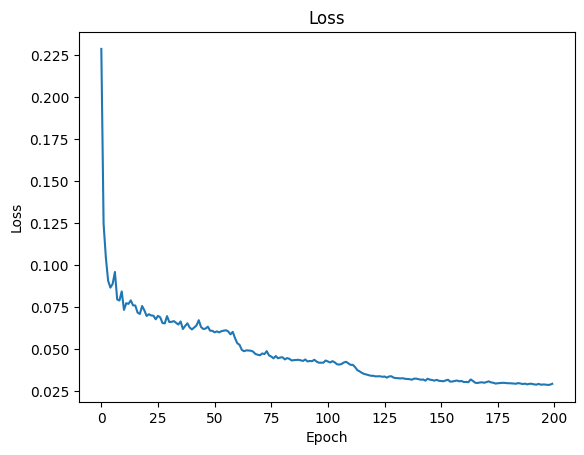

In [4]:
# 손실값 저장
loss = history.history['loss']

# 손실값 그래프 표현
plt.plot(loss)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

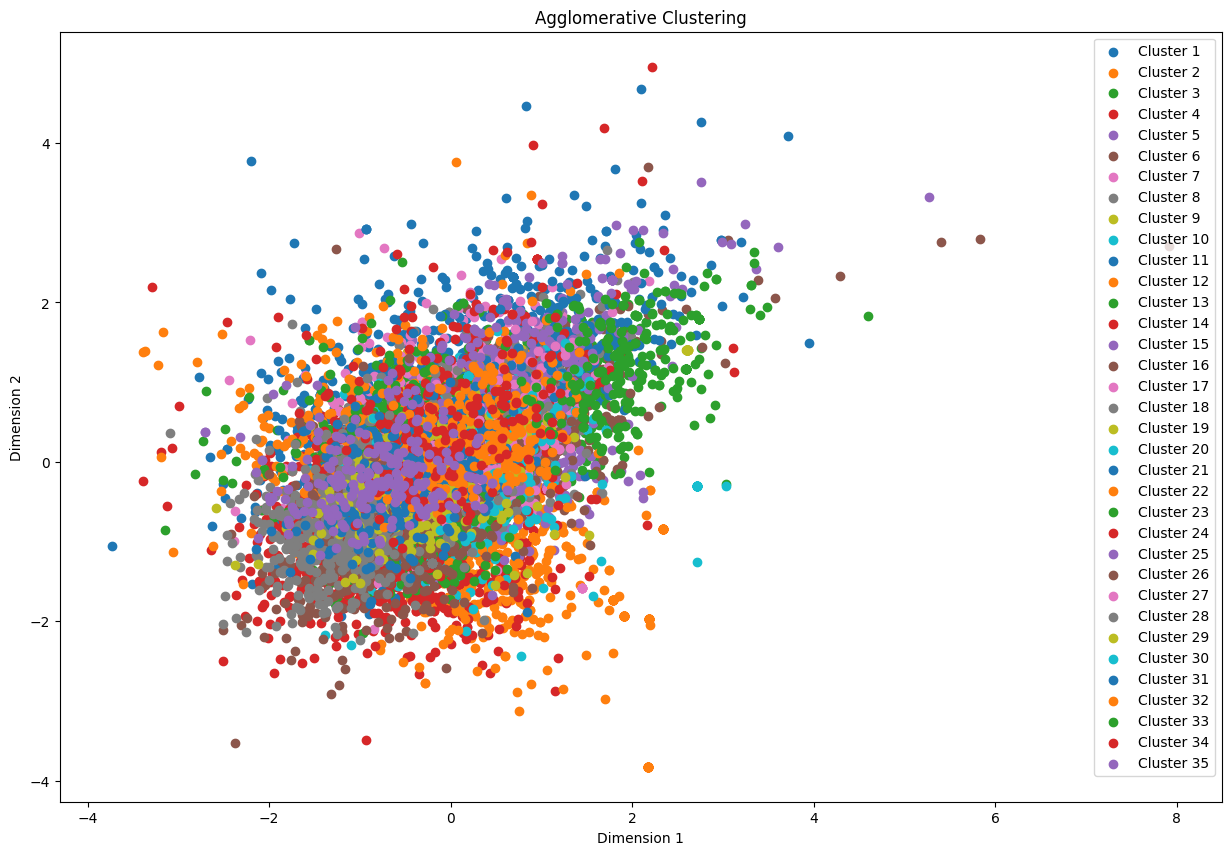

In [5]:
# 클러스터링 결과 시각화
plt.figure(figsize=(15, 10))
for cluster_id in range(35):
    cluster_samples = embedded_vectors_scaled[clusters == cluster_id]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], label=f'Cluster {cluster_id + 1}')

plt.title('Agglomerative Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [6]:
# 클러스터 결과를 데이터프레임에 추가
selected_data['Cluster'] = clusters

# 각 클러스터에 속한 책 목록 출력
for cluster_id in range(max(clusters) + 1):
    print(f"Cluster {cluster_id}:")
    cluster_books = selected_data[selected_data['Cluster'] == cluster_id]['자료명 저자'].tolist()
    print(cluster_books)
    print()

Cluster 0:
['호두까기 인형 E. T. A. 호프만', '우리 이야기 문학의 재발견 김창룡', '(외국인을 위한) 한국문학사 이선이', '(외국인을 위한) 한국 현대문학 산책 이선이', '중년여우, 들개, 사슴의 결투 김완수', '(대왕을 꿈꾼 조선의 왕) 연산 강기희', '나의 대표시를 말한다 최두석', '일류에는 로비가 있다 김정식', '현대시조, 정격으로의 길 이정자', '네르발 연구 김정아', '대화의 재발견 윌리엄 아이작스', '꿀맛 정두리', '언어 너머의 문학 전형준', '문학, 잉여의 몫 이수형', '너무 아름다운 꿈 최은미', '사비약 사비약 사비약눈 정완영', '과학기술의 상상력과 소통의 글쓰기 김성수', '브리꼴레르 유영만', '소로의 자연사 에세이 헨리 데이비드 소로우', '소설, 여자의 인생에 답하다 마르기트 쇤베르거', '작가의 내면, 작품의 틈새 심영의', '지금 이 순간이 기회입니다 김기태', '(마음을 다독이는) 한국의 명수필 피천득', '한중 현대문학 비교 연구 박남용', '분노를 부르는 말 호감을 부르는 말 민영욱', '셰익스피어 ＆ 컴퍼니 실비아 비친', '어느날 문득 발견한 행복 애너 퀸들런', '(카피라이터 정철의) 머리를 9하라 정철', '타이니 스토리 산전영미', '간결한 말씀 팀 페런', '(천년의 향기) 한시산책 기태완', '그대를 포함한 나에 대한 사색 백정미', '스피치 메이크업 문석현', '고려속악의 형성과 향유, 그 변용 여기현', '고전소설의 교육과 매체 권순긍', '영국단막극선집 송옥', '소설서사와 영상서사 송명희', '한국희곡 작가·작품 연구 한옥근', '문체 연구 방법의 이론과 실제 정해성', '엄마가 먼저 행복해져라 최연숙', '(관능의 빗장을 푼) 에로스의 사생활 윤향기', '인간 혐오자 몰리에르', '16세기 러시아 문학 막심 그렉', '이중의 변심 마리보', '현대시의 구조 후고 프리드리히', '아딜리와 형들 샤반 로버트', '서상기 왕실보', '스토리 스토리텔링 스토리디자인 한강희

In [7]:
# 클러스터 결과를 데이터프레임에 추가
selected_data['Cluster'] = clusters

# CSV 파일로 클러스터링 결과 저장
selected_data.to_csv("Word2Vec_GRUMHA_Agglomerative(n=35)_newnewnewtest.csv", index=False)

# 데이터 표준화
scaler = StandardScaler()
embedded_vectors_scaled = scaler.fit_transform(embedded_vectors)

# 시퀀스 형태로 변환
timesteps = 1  # LSTM/GRU에는 시퀀스를 한 번에 하나씩 제공
input_dim = embedded_vectors_scaled.shape[1]
embedded_vectors_scaled_seq = embedded_vectors_scaled.reshape((-1, timesteps, input_dim))

# LSTM 오토인코더 모델 정의
encoding_dim = 64

inputs = Input(shape=(timesteps, input_dim))

# 인코더
encoder_gru = GRU(encoding_dim, activation='elu', return_sequences=True)(inputs)
attention_output_encoder = MultiHeadAttention(num_heads=4, key_dim=encoding_dim)(encoder_gru, encoder_gru)
attention_output_encoder = LayerNormalization(epsilon=1e-6)(attention_output_encoder)
encoded = GRU(encoding_dim, activation='elu')(attention_output_encoder)

# 디코더
x_decoder = RepeatVector(timesteps)(encoded)
x_decoder = GRU(encoding_dim, activation='elu', return_sequences=True)(x_decoder)
attention_output_decoder = MultiHeadAttention(num_heads=4, key_dim=encoding_dim)(x_decoder, x_decoder)
attention_output_decoder = LayerNormalization(epsilon=1e-6)(attention_output_decoder)
decoded = GRU(input_dim, activation='elu', return_sequences=True)(attention_output_decoder)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)

# 오토인코더 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 오토인코더 모델 학습
history = autoencoder.fit(embedded_vectors_scaled_seq, embedded_vectors_scaled_seq, epochs=200, batch_size=32, shuffle=True)

# 인코더 모델 정의 (입력과 동일하게 정의)
encoder_inputs = Input(shape=(timesteps, input_dim))
x_encoder = GRU(encoding_dim, activation='elu', return_sequences=True)(encoder_inputs)
attention_output_encoder = MultiHeadAttention(num_heads=4, key_dim=encoding_dim)(x_encoder, x_encoder)
attention_output_encoder = LayerNormalization(epsilon=1e-6)(attention_output_encoder)
encoded = GRU(encoding_dim, activation='elu')(attention_output_encoder)
encoder = Model(encoder_inputs, encoded)

# 임베딩된 데이터에 대한 인코딩
encoded_vectors = encoder.predict(embedded_vectors_scaled_seq)

# 클러스터링
agg_clustering = AgglomerativeClustering(n_clusters=30)
clusters = agg_clustering.fit_predict(encoded_vectors)

# 클러스터 결과 출력
print("Clusters:", clusters)